In [1]:
import os
import requests

In [2]:
#CENSUS_DATASET = (
#   "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
#  "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
# "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
#)

#def download_data(path='data', urls=CENSUS_DATASET):
#    if not os.path.exists(path):
#        os.mkdir(path)
#    for url in urls:
#        response = requests.get(url)
#        name = os.path.basename(url)
#        with open(os.path.join(path, name), 'w') as f:
#            f.write(response.content)
#download_data()

In [3]:
import pandas as pd
import seaborn as sns

names =[
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
]

data =pd.read_csv('data/adult.data',names=names)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


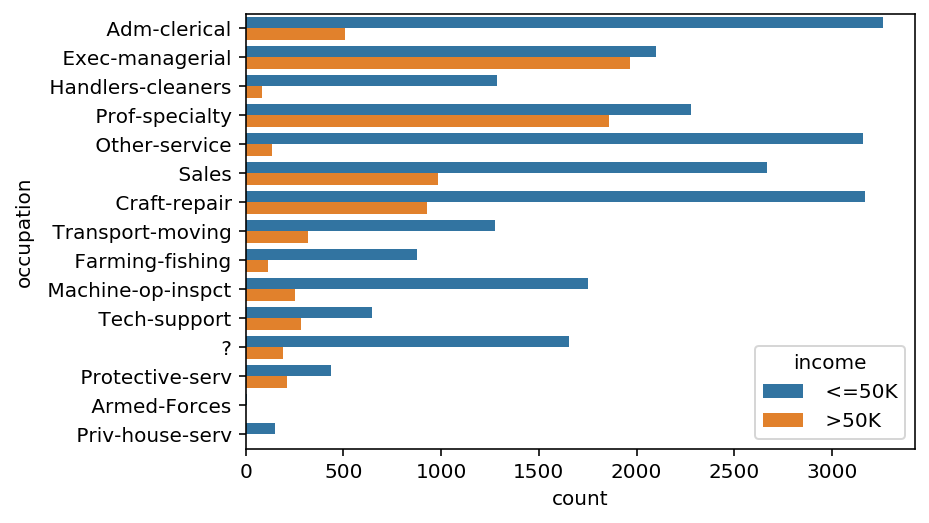

In [4]:
sns.countplot(y='occupation',hue='income',data=data)

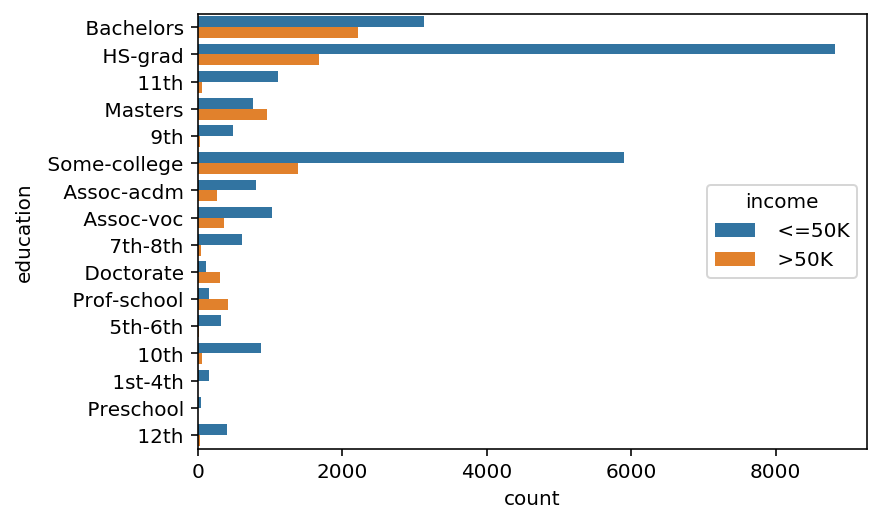

In [5]:
sns.countplot(y='education',hue='income',data=data)

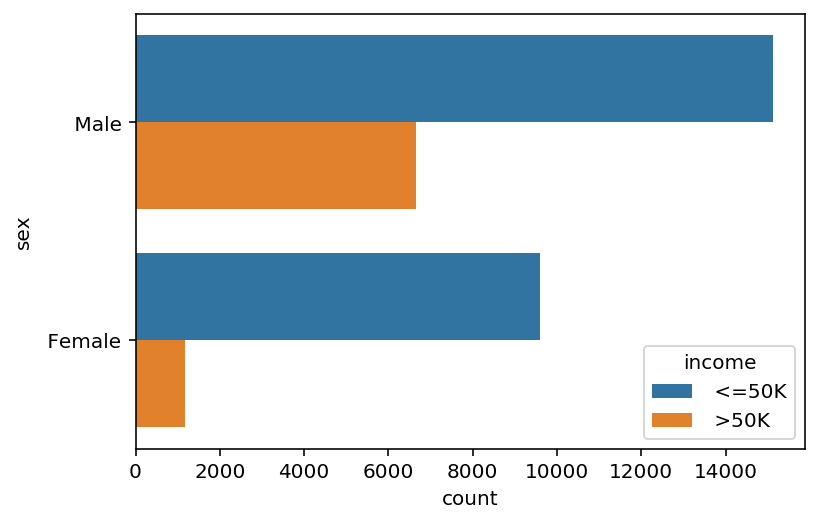

In [6]:
sns.countplot(y='sex',hue='income',data=data)

In [7]:
import json
meta = {
    'target_names': list(data.income.unique()),
    'feature_names': list(data.columns),
    'categorical_features': {
        column: list(data[column].unique())
        for column in data.columns
        if data[column].dtype == 'object'
    },
}
with open('data/meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

In [8]:
from sklearn.datasets.base import Bunch
def load_data(root='data'):
    # Load the meta data from the file
    with open(os.path.join(root, 'meta.json'), 'r') as f:
        meta = json.load(f)
    names = meta['feature_names']
    # Load the training and test data, skipping the bad row in the test data
    train = pd.read_csv(os.path.join(root, 'adult.data'), names=names)
    test  = pd.read_csv(os.path.join(root, 'adult.test'), names=names, skiprows=1)
    # Remove the target from the categorical features
    meta['categorical_features'].pop('income')
    # Return the bunch with the appropriate data chunked apart
    return Bunch(
        data = train[names[:-1]],
        target = train[names[-1]],
        data_test = test[names[:-1]],
        target_test = test[names[-1]],
        target_names = meta['target_names'],
        feature_names = meta['feature_names'],
        categorical_features = meta['categorical_features']
    )

In [9]:
dataset = load_data()

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None.
    """
    def __init__(self, columns=None):
        self.columns  = columns
        self.encoders = None
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode.
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns
        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns
        }
        return self
    def transform(self, data):
        """
        Uses the encoders to transform a data frame.
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])
        return output
encoder = EncodeCategorical(dataset.categorical_features.keys())
data = encoder.fit_transform(dataset.data)

In [11]:
from sklearn.preprocessing import Imputer
class ImputeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None.
    """
    def __init__(self, columns=None):
        self.columns = columns
        self.imputer = None
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to impute.
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns
        # Fit an imputer for each column in the data frame
        self.imputer = Imputer(missing_values=0, strategy='most_frequent')
        self.imputer.fit(data[self.columns])
        return self
    def transform(self, data):
        """
        Uses the encoders to transform a data frame.
        """
        output = data.copy()
        output[self.columns] = self.imputer.transform(output[self.columns])
        return output
imputer = ImputeCategorical(['workclass', 'native-country', 'occupation'])
data = imputer.fit_transform(data)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
# we need to encode our target data as well.
yencode = LabelEncoder().fit(dataset.target)
# construct the pipeline
census = Pipeline([
        ('encoder',  EncodeCategorical(dataset.categorical_features.keys())),
        ('imputer', ImputeCategorical(['workclass', 'native-country', 'occupation'])),
        ('classifier', LogisticRegression())
    ])
# fit the pipeline
census.fit(dataset.data, yencode.transform(dataset.target))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('encoder',
                 EncodeCategorical(columns=dict_keys(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']))),
                ('imputer',
                 ImputeCategorical(columns=['workclass', 'native-country',
                                            'occupation'])),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [14]:
from sklearn.metrics import classification_report
# encode test targets, and strip traililng '.'
y_true = yencode.transform([y.rstrip(".") for y in dataset.target_test])
# use the model to get the predicted value
y_pred = census.predict(dataset.data_test)
# execute classification report
print(classification_report(y_true, y_pred, target_names=dataset.target_names))

              precision    recall  f1-score   support

       <=50K       0.82      0.96      0.88     12435
        >50K       0.69      0.31      0.43      3846

    accuracy                           0.80     16281
   macro avg       0.75      0.63      0.66     16281
weighted avg       0.79      0.80      0.77     16281



In [0]:
import pickle
def dump_model(model, path='data', name='classifier.pickle'):
    with open(os.path.join(path, name), 'wb') as f:
        pickle.dump(model, f)
dump_model(census)

In [19]:
def load_model(path='data/classifier.pickle'):
    with open(path,'rb') as f:
        return pickle.load(f)
def predict(model,meta=meta):
    data = {} #Store the input from the user
    
    for column in meta['feature_names'][:-1]:
        # Get valid response
        valid = meta['categorical_feautres'].get(column)
        
        #prompt the user for answe until good
        while True:
            val = " " + raw_input("enter {} >".format(column))
            if valid and val not in valid:
                print("Not valid,Choose one of {}".format(valid))
            else:
                data[column] = val
                break
    #Create prediction and label
    yhat = model.predict(pd.DataFrame([data]))
    return yencode.inverse_tranform(yhat)

#Execute the interface
model = load_model()
predict(model)

sklearn.pipeline.Pipeline